In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.tree import DecisionTreeClassifier as Tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import sem

In [2]:
def blahut_arimoto(Pygw, log_base=2, epsilon=1e-12, max_iter=1e3):
    """
    Performs the Blahut-Arimoto algorithm to compute the channel capacity
    given a channel P_ygx.
    Parameters
    ----------
    Pygw: shape (m, c).
        transition matrix of the channel with m inputs and c outputs.
    log_base: int.
        base to compute the mutual information.
        log_base = 2: bits, log_base = e: nats, log_base = 10: dits.
    epsilon: float.
        error tolerance for the algorithm to stop the iterations.
    max_iter: int.
        number of maximal iteration.
    Returns
    -------
    Capacity: float.
        channel capacity, or the maximum information it can be transmitted
        given the input-output function.
    pw: array-like.
        array containing the discrete probability distribution for the input
        that maximizes the channel capacity.
    loop: int
        the number of iteration.
    resource: https://sites.ecse.rpi.edu/~pearlman/lec_notes/arimoto_2.pdf
    """
    ## check inputs
    # assert np.abs(Pygw.sum(axis=1).mean() - 1) < 1e-6
    # assert Pygw.shape[0] > 1

    m = Pygw.shape[0]
    c = Pygw.shape[1]
    Pw = np.ones((m)) / m
    for cnt in range(int(max_iter)):
        ## q = P_wgy
        q = (Pw * Pygw.T).T
        q = q / q.sum(axis=0)

        ## r = Pw
        r = np.prod(np.power(q, Pygw), axis=1)
        r = r / r.sum()

        ## stoppung criteria
        if np.sum((r - Pw) ** 2) / m < epsilon:
            break
        else:
            Pw = r

    ## compute capacity
    capacity = 0
    for i in range(m):
        for j in range(c):
            ## remove negative entries
            if r[i] > 0 and q[i, j] > 0:
                capacity += r[i] * Pygw[i, j] * np.log(q[i, j] / r[i])

    capacity = capacity / np.log(log_base)
    return capacity, r, cnt+1


In [5]:
i = 0
npoints = 21
cap = np.zeros((npoints,npoints))
for p in tqdm(np.linspace(0.001,1-.001,npoints)):
    j = 0
    for q in np.linspace(0.001,1-.001,npoints):
        P = np.array([[p,1-p],[q,1-q]])
        cap[i,j] = 2**np.sqrt(blahut_arimoto(P)[0])
        j+=1
    i+=1
    
x = np.round(np.linspace(0.001,1-.001,npoints),decimals=3)
y = np.round(np.linspace(0.001,1-.001,npoints),decimals=3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 14.70it/s]


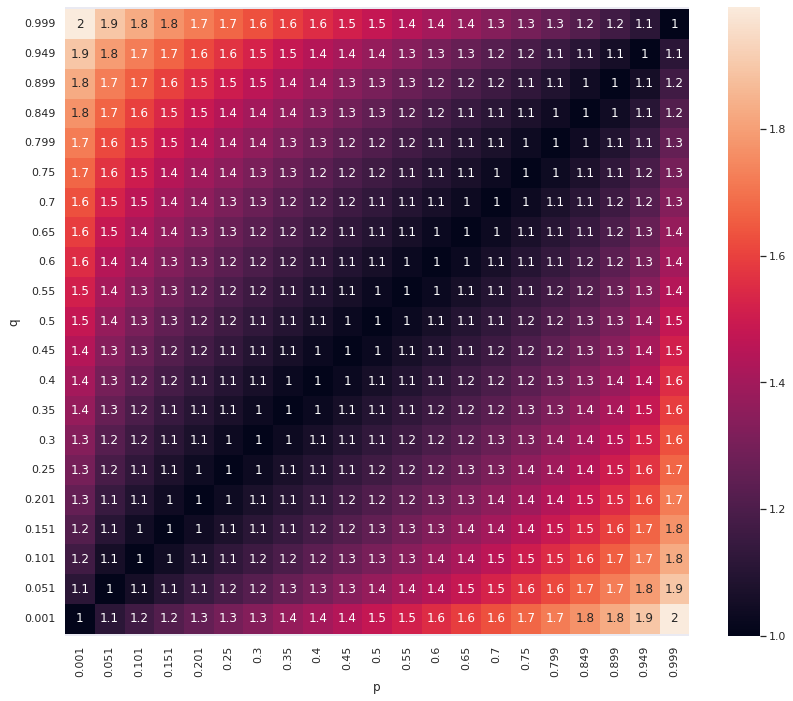

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.9))
sns.heatmap(cap, annot=True, xticklabels=x, yticklabels=y, ax=ax)
ax.axis('equal')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('capacity-convexity-sm.png', format='png', dpi=300, bbox_inches='tight');

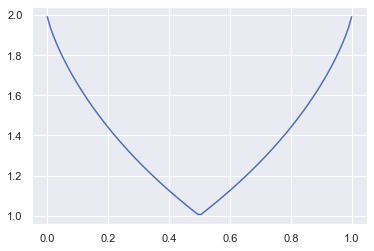

In [80]:
c = np.zeros(100)
pv = np.linspace(0.001,.999,100)
k = 0
cap = np.zeros(100)
for p in pv:
    P = np.array([[p,1-p],[1-p,p]])
    c[k] = 2**np.sqrt(1+ p*np.log2(p)+(1-p)*np.log2(1-p))
    cap[k] = blahut_arimoto(P)[0]
    k+=1
    
plt.plot(pv,c)